# What is the deep learning workflow?
<img src="img/deep learning workload.png" alt="pizza in stone oven">

# What is the ETL pipeline?
ETL = Extract, Transform, Load<br/>
<b>1. Prepare the data(ETL)</b><br/>
2. Build the model<br/>
3. Train the model<br/>
4. Analyze the model's result<br/>

## What is the MNIST dataset?
The MNIST dataset, Modified National Institute of Standards and Technology database, is a famous dataset of handwritten digits that is commonly used for training image processing systems for machine learning. NIST stands for National Institute of Standards and Technology.

The M in MNIST stands for modified, and this is because there was an original NIST dataset of digits that was modified to give us MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# other 3rd party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import itertools
import pdb
import copy
from tqdm import tqdm
from GPUtil import showUtilization as gpu_usage

torch.set_printoptions(linewidth=120) # just specifies the printing string line width of pytorch
matplotlib.rcParams['figure.figsize'] = [18, 12]

# some experiments with cuda
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics

print("Cuda version: ", torch.version.cuda)
print("Cudnn enabled?: ", torch.backends.cudnn.enabled)
print("Cudnn version: ", torch.backends.cudnn.version())
print("torch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)
print("numpy version: ", np.__version__)

Cuda version:  10.1
Cudnn enabled?:  True
Cudnn version:  7603
torch version:  1.4.0.dev20191207
torchvision version:  0.5.0.dev20191208
numpy version:  1.17.4


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Tensor backend uses: ", device)

Tensor backend uses:  cuda


In [3]:
# training hyperparameters
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 1000
EPOCHS = 25
# contour plot resolution
STEPS = 40

In [4]:
# number of subprocesses to use for data loading
num_workers = 1
# percentage of training set to use as validation
valid_size = 0.2
# Path of where are your data. to prevent double donwload, i am using root directory.
data_path = "~/.pytorch"

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# choose the training and test datasets
train_data = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## PyTorch Dataset: Working with the training set
### Exploring the data

In [5]:
len(train_data)

60000

In [6]:
train_data.targets # label tensor

tensor([9, 0, 0,  ..., 3, 0, 5])

If we want to see how many of each label exists in the dataset, we can use the PyTorch bincount() function like so:

This result shows FashionMNIST is uniform for respect to each class.
This dataset is balanced.

<b>Balanced</b>: Each class has equal number of data.(Should be)<br/>
<b>Unbalanced</b>: One or more classes contains more or less data.(breaks almost everything)([oversample](https://arxiv.org/abs/1710.05381) the less common class)<br/>
<b>oversample</b>: repeat same same

In [7]:
train_data.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

### Datasets
** There is no batch. It iterates one by one

In [8]:
sample = next(iter(train_data))
image, label = sample

In [9]:
len(sample)

2

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
image.squeeze().shape

torch.Size([28, 28])

In [12]:
torch.tensor(label).shape

torch.Size([])

tensor(9)


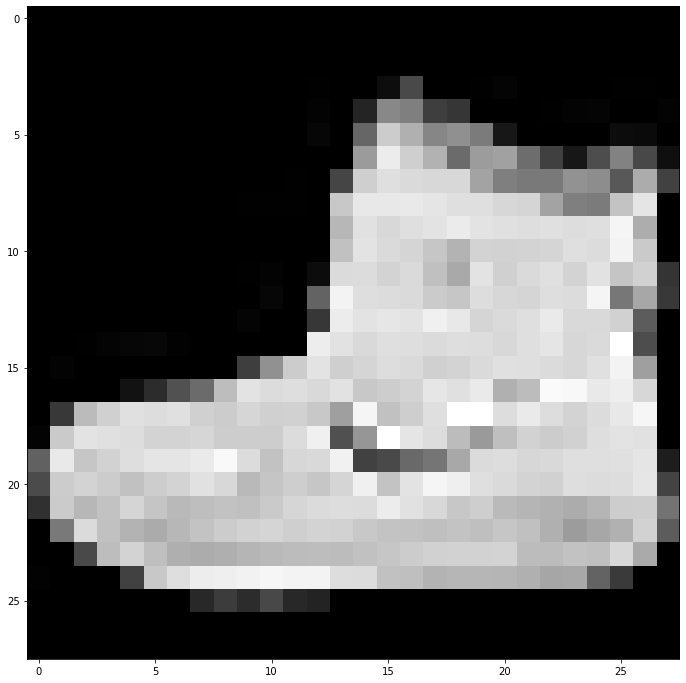

In [13]:
plt.imshow(image.squeeze(), cmap="gray")
print(torch.tensor(label))

### Dataloader
There is a batch. It iterates batch by batch

In [14]:
sample = enumerate(train_loader)
batch_idx, sample_tuple = next(sample)
(image, label) = sample_tuple
print(len(sample_tuple))
print(type(sample_tuple))

2
<class 'list'>


reminder: batch size is 1280

(batch size, number of color channels, image height, image width)

In [15]:
image.shape

torch.Size([1000, 1, 28, 28])

In [16]:
image.squeeze().shape

torch.Size([1000, 28, 28])

In [17]:
label.shape

torch.Size([1000])

label: tensor(6)


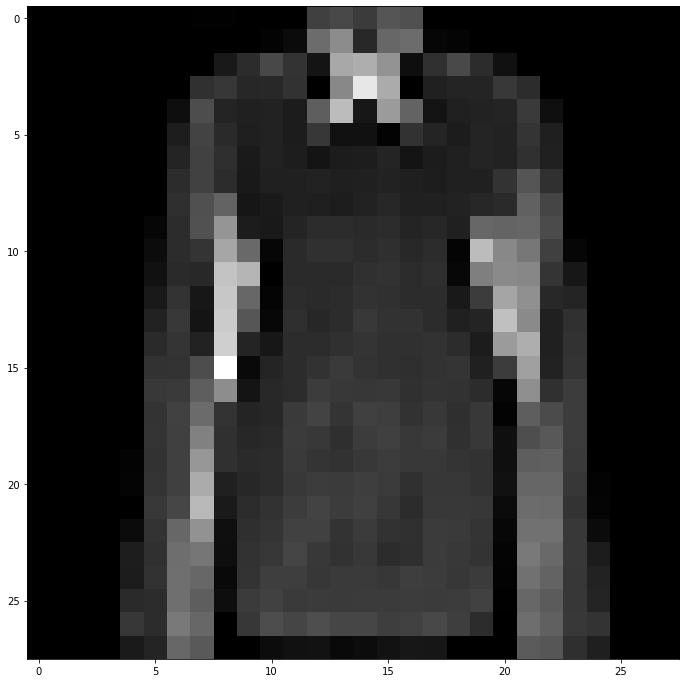

In [18]:
idx=0
plt.imshow(image[idx].squeeze(), cmap='gray')
print('label:', label[idx])

torchvision has a good tools to make plot

In [19]:
grid = torchvision.utils.make_grid(image, nrow=10)

There is an alternative to transpoze in Pytorch<br/>
numpy way: np.transpose(grid, (1,2,0))<br/>
Pytorch way: grid.permute(1,2,0)<br/>
There is also transpose function in Pytorch but it only take 2 paramter<br/>
Example:<br/>
a = torch.rand(1,2,3,4)<br/>
print(a.transpose(0,3).transpose(1,2).size())<br/>
print(a.permute(3,2,1,0).size())<br/>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([6, 9, 7, 1, 0, 7, 9, 8, 5, 4, 5, 0, 2, 1, 1, 4, 8, 0, 0, 0, 0, 2, 4, 5, 0, 8, 2, 0, 3, 3, 0, 6, 8, 1, 6, 5, 1,
        9, 7, 3, 3, 6, 4, 7, 6, 1, 0, 8, 6, 7, 6, 7, 2, 1, 2, 7, 0, 1, 5, 4, 9, 1, 2, 2, 8, 6, 5, 3, 7, 7, 7, 7, 8, 9,
        0, 6, 5, 9, 4, 0, 8, 3, 0, 7, 9, 6, 2, 0, 9, 5, 5, 3, 6, 3, 2, 8, 7, 6, 9, 7, 2, 8, 8, 3, 8, 6, 8, 7, 4, 0, 0,
        2, 8, 3, 8, 9, 4, 5, 2, 3, 9, 8, 9, 0, 6, 6, 4, 4, 8, 3, 8, 8, 3, 4, 4, 0, 4, 5, 5, 9, 4, 8, 4, 7, 7, 0, 3, 2,
        7, 6, 8, 9, 0, 7, 8, 8, 9, 0, 1, 0, 6, 8, 6, 9, 7, 3, 5, 3, 8, 1, 9, 0, 0, 3, 4, 9, 8, 8, 7, 5, 9, 0, 2, 5, 6,
        9, 4, 6, 2, 3, 6, 2, 2, 3, 2, 6, 1, 0, 5, 0, 5, 2, 0, 2, 3, 2, 4, 1, 6, 3, 4, 0, 0, 8, 3, 3, 6, 7, 6, 7, 7, 0,
        6, 4, 1, 4, 1, 3, 3, 7, 6, 6, 2, 8, 6, 4, 5, 4, 3, 2, 8, 9, 9, 6, 1, 4, 9, 7, 3, 7, 9, 3, 6, 8, 7, 4, 0, 7, 0,
        2, 7, 8, 2, 7, 1, 7, 7, 9, 7, 0, 2, 3, 0, 7, 7, 9, 7, 1, 3, 8, 6, 0, 3, 0, 9, 0, 0, 7, 3, 3, 9, 5, 6, 3, 8, 6,
        2, 0, 8, 4, 2, 0, 7, 6, 2, 4, 1,

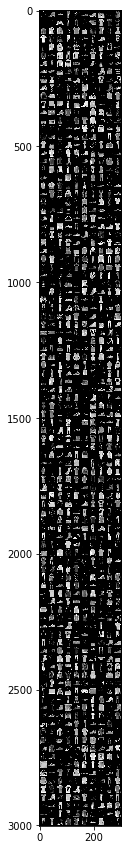

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0)) #np.transpose(grid, (1,2,0))
print('labels:', label)

Okey. There is lots of images but I just want to see some of them. I should create another dataloader object. So I can see with image is correspoing to the label<br/>
Look good for me.

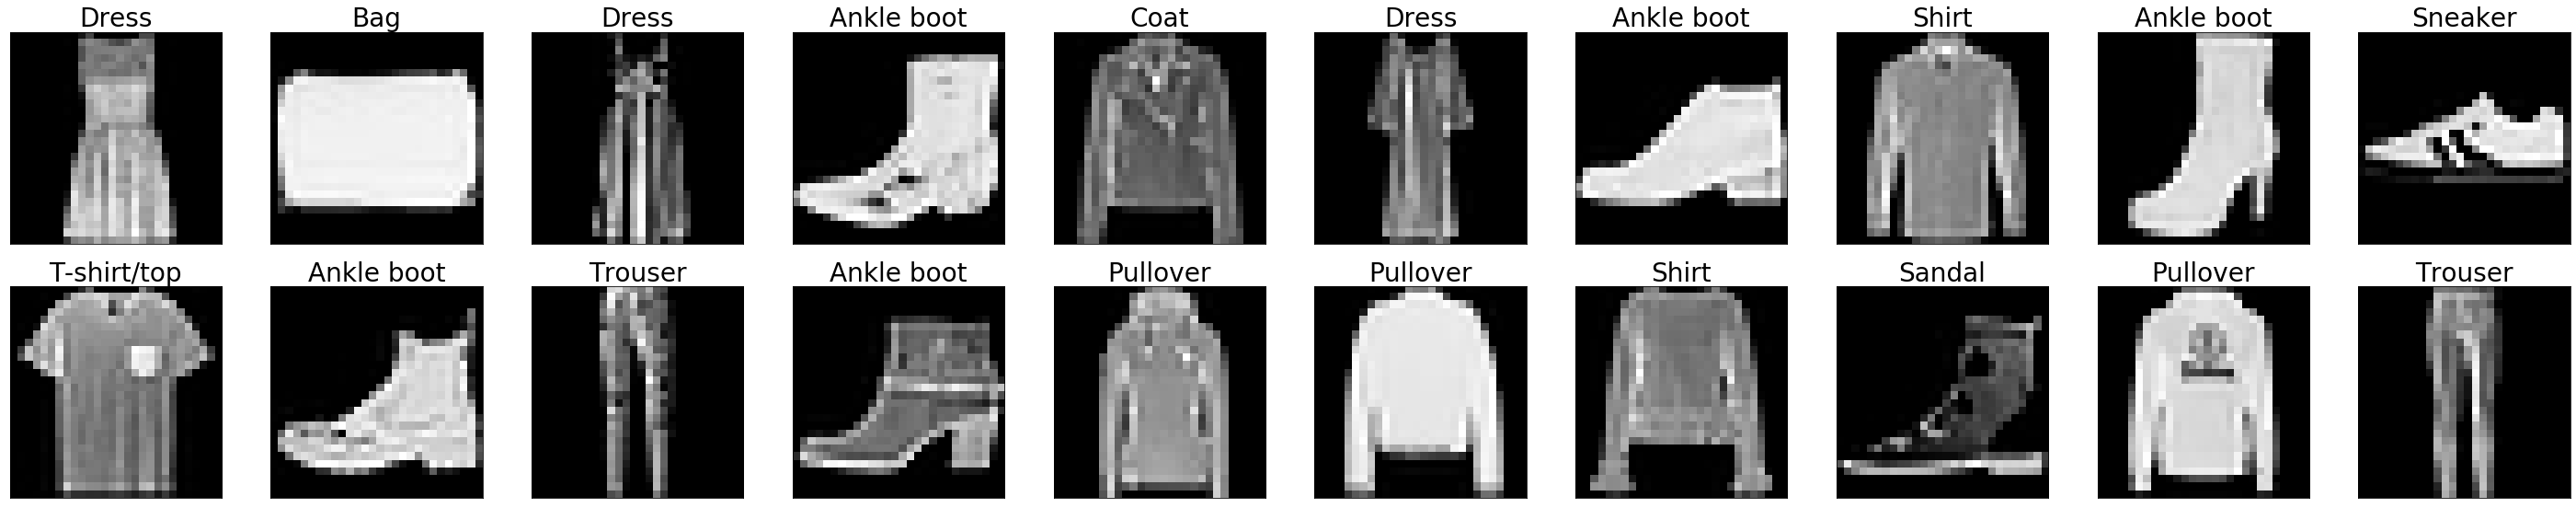

In [21]:
how_many_to_plot = 20

train_loader2 = torch.utils.data.DataLoader(
    train_data, batch_size=1, shuffle=True
)

mapping = dict(enumerate(classes))

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader2, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    fig = plt.imshow(image.reshape(28,28), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(mapping[label.item()], fontsize=28)
    if (i >= how_many_to_plot): break
plt.show()

### Create the model
Model creation is the simplest step according to me. Main time consumption is preprocessing the data and train steps.<br/>
I am creating very simple model and train function<br/>
but you should know how to claculate output of conv layers
[deeplizard-CNN Output Size Formula](https://deeplizard.com/learn/video/cin4YcGBh3Q)

In [24]:
class Network(nn.Module):
    def __init__(self): # should try xavier_normal_
        super(Network,self).__init__() #extents and access the all torch nn module
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)

        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
        self.out = nn.Linear(in_features=60, out_features=10)
        nn.init.kaiming_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0)

    def forward(self, t): # layer 1 is the t
        # layer 2
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # layer 3
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # layer 4
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)
        # layer 5
        t = self.fc2(t)
        t = F.relu(t)
        # layer 6
        t = self.out(t)
        return t

def train(model, optimizer, criterion, train_loader, epochs):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        # gpu_usage()
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch
            #x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True).long()

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

IndentationError: unexpected indent (<ipython-input-24-46bd7ea24712>, line 75)

In [25]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=LR)
optimizer.zero_grad()
criterion = torch.nn.CrossEntropyLoss()
print(model)

NameError: name 'Network' is not defined

## Loss function visualization
I have a one more extra step.

### Points in Parameter Space
First I will take a copy of network before the train

In [26]:
# stores the initial point in parameter space
model_initial = copy.deepcopy(model.cpu())

NameError: name 'model' is not defined

Two common points of interest are the model initialization, and the model's final parameters after training. Similarly to the cell above, we can make a copy of the model after training. A copy of the model can be made at any time - this is up to the user, of course.<br/>
Note: Currently this tool cannot operate on gpu :|

There is a allegory in deep learning. "Nonsense is the same thing every time and expect different results." But it is a stochastic process so that you can expect differenct results each time :)

In [27]:
# https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4
# the GPU low usage problem is the default mnist data loader.
# check the code if there isn't any releated to torch or gpu 
# experiment: https://github.com/feedly/ml-demos/blob/master/source/gpu.py#L42

train(model, optimizer, criterion, train_loader, EPOCHS)
torch.save(model.state_dict(), 'model_FashionMnist.pt')

model.load_state_dict(torch.load('model_FashionMnist.pt'))
model_final = copy.deepcopy(model.cpu())

NameError: name 'train' is not defined

### Linear Interpolations of Loss between Two Points

In [28]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)

# compute loss data
loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=True)

NameError: name 'criterion' is not defined

In [29]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

NameError: name 'loss_data' is not defined

Planar Approximations of Loss Around a Point

In [30]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)

NameError: name 'model_final' is not defined

In [31]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

NameError: name 'loss_data_fin' is not defined

NameError: name 'loss_data_fin' is not defined

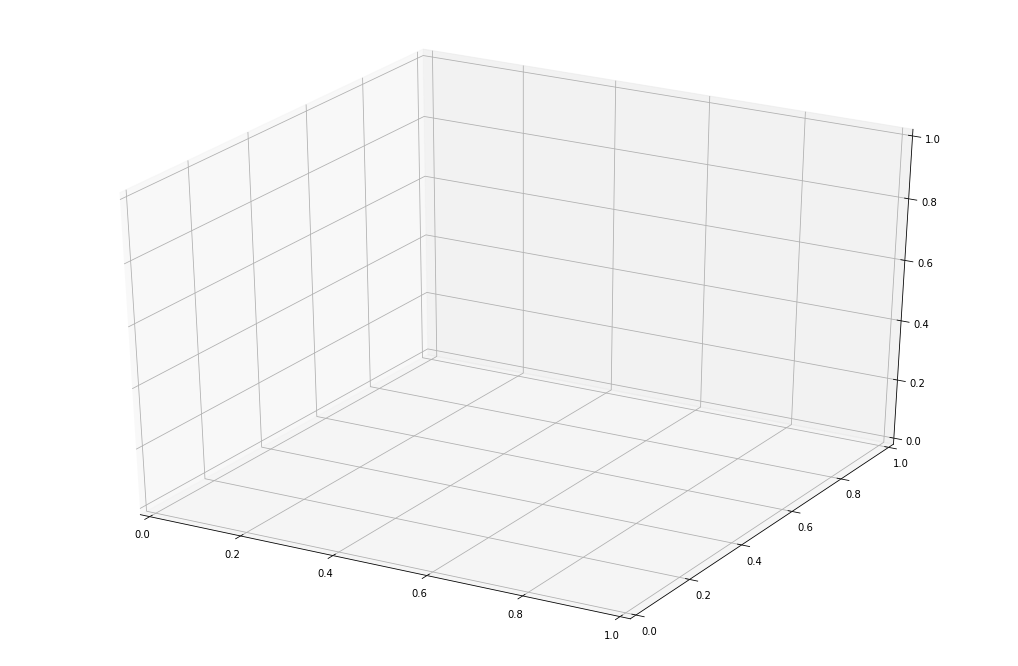

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

I can't get all predictions all in once so that concatenate to tensor<br/>
<b>@torch.no_grad()</b> function decorator is another way to disable autogradient feature. Whenever use that function, pytorch won't calculate gradient.<br/>
If you want to use less memory and gain more speed, you should disable autogradient feature if it is unneccesery.

Resource: https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [33]:
@torch.no_grad()
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds),
            dim=0
        )
    return all_preds

Get predictions and make a <b>confusion matrix</b> to examine model<br/>
<b>How to make Confusion Matrix without any libraries?</b>

In [34]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)
    preds_correct = get_num_correct(train_preds, train_data.targets)
    print("total correct: ", preds_correct)
    print("accuracy: ", preds_correct/len(train_data))

NameError: name 'model' is not defined

In [35]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [36]:
train_preds.argmax(dim=1)

NameError: name 'train_preds' is not defined

Stack all correct labels and predicted classes

In [37]:
stacked = torch.stack(
    (
         train_data.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)
print(stacked)
print(stacked.shape)
print(stacked[0].tolist())

NameError: name 'train_preds' is not defined

All bunmbers representes the index of confusion matrix. Tensor contains pairs of with class is True label with one is predicted. If pair is contains same numbers it will placed on diagonal.<br/>
Diagonal is the wanted result.

In [38]:
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
print(cmt)

NameError: name 'stacked' is not defined

If you don't understand, don't worry. Sklearn has a good function to calculate confusion matrix.

In [39]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

You can see how many class on the right bar.

In [40]:
cm = confusion_matrix(train_data.targets, train_preds.argmax(dim=1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)

NameError: name 'train_preds' is not defined

# Concatenate vs Stack
You can heard Concatenate and Stack from lots of framework. Numpy, Pytorch, Tensorflow
<div class="display">
                                                    Concatenating joins a sequence of tensors along an existing axis, and stacking joins a sequence of tensors along a new axis.
                                                </div>

In [41]:
??torch.cat #nteract doesn't show help

Object `torch.cat #nteract doesn't show help` not found.


In [42]:
??torch.stack #nteract doesn't show help

Object `torch.stack #nteract doesn't show help` not found.


In [43]:
t1 = torch.tensor([1,1,1])
t1.unsqueeze(dim=0)

tensor([[1, 1, 1]])

In [44]:
t1.unsqueeze(dim=1)

tensor([[1],
        [1],
        [1]])

In [45]:
print(t1.shape)
print(t1.unsqueeze(dim=0))
print(t1.unsqueeze(dim=1))

torch.Size([3])
tensor([[1, 1, 1]])
tensor([[1],
        [1],
        [1]])


Lets see what is the difference

In [46]:
t1 = torch.tensor([1,1,1])
t2 = torch.tensor([1,1,1]) *2
t3 = torch.tensor([1,1,1]) *3

cat usses existing axis
stack create an axis

In [47]:
torch.cat(
    (t1,t2,t3),
    dim=0
)

tensor([1, 1, 1, 2, 2, 2, 3, 3, 3])

stack create empty axis and stack them into.<br/>
creates -> []<br/>
[<br/>
    [[1,1,1]]<br/>
]<br/>
...<br/>
[<br/>
    [[1,1,1]],<br/>
    [[2,2,2]]<br/>
]<br/>
...<br/>
[<br/>
    [[1,1,1]],<br/>
    [[2,2,2]],<br/>
    [[3,3,3]]<br/>
]<br/>

In [48]:
torch.stack(
    (t1,t2,t3),
    dim=0
)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

If I want to make stack effect with cat, you should use unsqueeze(0) function.

In [49]:
torch.cat(
    (t1.unsqueeze(0), 
     t2.unsqueeze(0), 
     t3.unsqueeze(0)
    ),
    dim=0
)

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

Note that we cannot concat this sequence of tensors along the second axis because there currently is no second axis in existence, so in this case, stacking is our only option.

In [50]:
torch.stack(
    (t1,t2,t3),
    dim=1
)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [51]:
# error
torch.cat(
    (t1,t2,t3),
    dim=1
)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [52]:
# error corrected
torch.cat(
    (
         t1.unsqueeze(1)
        ,t2.unsqueeze(1)
        ,t3.unsqueeze(1)
    )
    ,dim=1
)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

### Joining Images into a Single Batch

stack

In [53]:
t1 = torch.zeros(3,28,28)
t2 = torch.zeros(3,28,28)
t3 = torch.zeros(3,28,28)

torch.stack(
    (t1,t2,t3),
    dim=0
).shape

torch.Size([3, 3, 28, 28])

concatenate

In [54]:
t1 = torch.zeros(1,3,28,28)
t2 = torch.zeros(1,3,28,28)
t3 = torch.zeros(1,3,28,28)

torch.cat(
    (t1,t2,t3),
    dim=0
).shape

torch.Size([3, 3, 28, 28])

Joining Images with an Existing Batch

In [55]:
batch = torch.zeros(3,3,28,28)
t1 = torch.zeros(3,28,28)
t2 = torch.zeros(3,28,28)
t3 = torch.zeros(3,28,28)

torch.cat(
    (
        batch
        ,torch.stack(
            (t1,t2,t3)
            ,dim=0
        )
    )
    ,dim=0
).shape

torch.Size([6, 3, 28, 28])

In [56]:
batch = torch.zeros(3,3,28,28)
t1 = torch.zeros(3,28,28)
t2 = torch.zeros(3,28,28)
t3 = torch.zeros(3,28,28)

torch.cat(
    (
        batch
        ,t1.unsqueeze(0)
        ,t2.unsqueeze(0)
        ,t3.unsqueeze(0)
    )
    ,dim=0
).shape

torch.Size([6, 3, 28, 28])